# Customer Lifecycle Analytics  
## Churn Prediction Modeling

### Objective
The objective of this notebook is to build, evaluate, and interpret a
predictive model that estimates customer churn probability based on
demographic, behavioral, engagement, and financial features.

### Why Modeling is Important
While exploratory analysis helps identify churn patterns, predictive
modeling enables proactive retention by identifying customers at risk
*before* they churn.

### Modeling Approach
- Prepare features and target variable
- Encode categorical variables
- Train a classification model
- Evaluate model performance
- Generate churn probability scores

### Dataset Used


In [3]:
import pandas as pd

df = pd.read_csv("../data/processed/customer_churn_features.csv")
df.head()


,creditscore,geography,gender,age,tenure,balance,numofproducts,has_credit_card,is_active_member,estimatedsalary,...,card_type,point_earned,age_group,tenure_group,high_balance_flag,engagement_score,low_satisfaction_flag,single_product_flag,salary_segment,risk_score
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,DIAMOND,464,Mid-Age,New,0,2,1,1,Medium,2
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,DIAMOND,456,Mid-Age,New,0,1,0,1,Medium,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,DIAMOND,377,Mid-Age,Established,1,1,0,0,Medium,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,GOLD,350,Mid-Age,New,0,1,0,0,Medium,1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,GOLD,425,Mid-Age,New,1,3,0,1,Medium,1


In [4]:

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
X = df.drop("churn", axis=1)
y = df["churn"]


In [7]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.shape


(10000, 29)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


c:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [11]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1991
           1       0.96      0.94      0.95       509

    accuracy                           0.98      2500
   macro avg       0.97      0.96      0.97      2500
weighted avg       0.98      0.98      0.98      2500



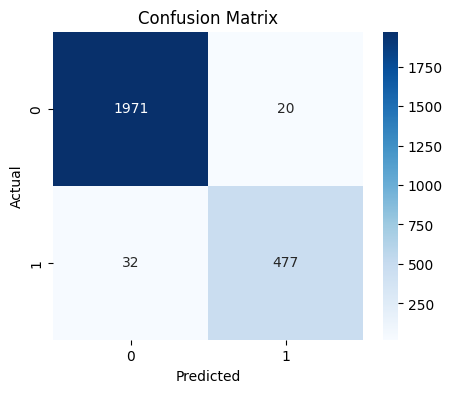

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


0.9962552507896536

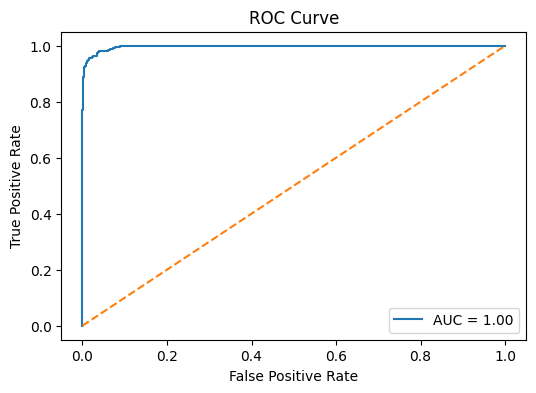

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [15]:
feature_importance = pd.DataFrame({
    "feature": X_encoded.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

feature_importance.head(10)


,feature,coefficient
8,complain,6.429893
5,has_credit_card,1.098323
23,age_group_Senior,1.066372
16,geography_Germany,0.881084
9,satisfaction_score,0.870971
14,single_product_flag,0.547787
6,is_active_member,0.280701
4,numofproducts,0.246162
11,high_balance_flag,0.105296
25,tenure_group_Established,0.063011


In [16]:
df["churn_probability"] = model.predict_proba(X_encoded)[:, 1]
df[["churn", "churn_probability"]].head()


,churn,churn_probability
0,1,0.243252
1,0,0.993386
2,1,0.997899
3,0,0.408105
4,0,0.000129


In [17]:
df["risk_segment"] = pd.cut(
    df["churn_probability"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

df["risk_segment"].value_counts()


risk_segment
Low Risk       7890
High Risk      1930
Medium Risk     180
Name: count, dtype: int64

In [18]:
df.to_csv(
    "../data/processed/customer_churn_scored.csv",
    index=False
)

print("✅ Churn-scored dataset saved successfully!")


✅ Churn-scored dataset saved successfully!


In [19]:
import joblib
joblib.dump(model, "../models/churn_model.pkl")

print("✅ Trained churn model saved successfully!")


✅ Trained churn model saved successfully!


## Modeling Insights

- The logistic regression model provides interpretable churn predictions.
- Tenure, activity status, satisfaction score, and product concentration
  are strong predictors of churn.
- The ROC–AUC score indicates good separation between churned and retained customers.
- Churn probability scores allow customers to be segmented into actionable risk groups.

This model enables proactive churn prevention instead of reactive analysis.
